In [1]:
import json
import pandas as pd
import numpy as np

from scipy.stats import ttest_1samp 

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from nilearn.image import new_img_like, smooth_img
from nilearn.datasets import load_mni152_template
import nibabel as nib


from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("output_paths", {}).get("stats")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading main dataframe

In [2]:
meta_donor_df_filtered = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered.csv"))
meta_donor_df_filtered["gene_expression_values"] = meta_donor_df_filtered["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df_filtered["gene_expression_values"][0][0])

3.4665720939923


Stats dataframe

In [3]:
stats_df = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))
df =  stats_df.copy()

df.head(3)

,brain_region,gene_id,sum_expression,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,...,power_256,t_stat_256,effect_size_512,p-value_512,power_512,t_stat_512,effect_size_1024,p-value_1024,power_1024,t_stat_1024
0,4012,2541,7305.189875,0.723958,0.039062,0.579479,31.0,0.170152,0.231873,0.159962,...,0.988638,21436.0,0.179155,8.732317e-07,0.991882,81676.0,0.285270,1.100408e-22,1.000000,354526.0
1,4013,1259,9883.385544,0.576161,0.125000,0.431013,27.0,-0.327191,0.798126,0.001882,...,0.991683,21943.0,0.152272,4.490161e-06,0.963761,80536.0,0.088223,1.216660e-05,0.880289,302356.0
2,4013,2541,12655.801370,0.716566,0.054688,0.572157,30.0,0.205089,0.247711,0.194567,...,0.999900,22748.0,0.324791,3.459548e-14,1.000000,90748.0,0.264883,9.052327e-20,1.000000,347825.0


### Averaging MNI Locations per Brain Region

In [4]:
import re
# Access paths
RAW_DATA_PATH = project_root / parser.get("data_paths", {}).get("raw_data") 

donor_pattern = r"^normalized_microarray_donor\d+$"
donor_dirs = [d for d in RAW_DATA_PATH.iterdir() if d.is_dir() and re.match(donor_pattern, d.name)]

donors_sa = []
for donor_path in donor_dirs:
    # Processing path
    logger.info(f"Processing data of {donor_path}")
    donors_sa.append(load_df_from_csv(donor_path / "SampleAnnot.csv"))

donors_sa_df=pd.concat(donors_sa)
donors_sa_df.head(3)

Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor10021
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor14380
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor9861
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor15496
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor12876
Processing data of /home/affectiva/git/Gene-Expression-Analysis/data/raw/normalized_microarray_donor15697


,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z
0,4322,10,5705,CX,Cl,"claustrum, left",978619,120,91,71,-29.2,5.8,-2.6
1,4291,10,5713,CX,Acb,"nucleus accumbens, left",998603,103,96,71,-10.1,5.9,-8.4
2,4292,10,5721,CX,Acb,"nucleus accumbens, right",998604,86,95,69,8.9,8.5,-7.4


Averaging the mni coordinates for every brain region

In [5]:
average_mni = donors_sa_df.groupby('structure_id')[['mni_x', 'mni_y', 'mni_z']].mean().reset_index()

print(average_mni.head(3))

   structure_id      mni_x     mni_y      mni_z
0          4012 -37.463636 -0.681818  44.600000
1          4013 -36.578947 -7.142105  58.152632
2          4014 -45.938889 -9.155556  43.105556


Averaging effect size per brain region in each cluster

In [6]:
OUTPUT_DATA = project_root / parser.get("output_paths", {}).get("stats")
cluster_0_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_0.csv'))
cluster_1_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_1.csv'))
cluster_2_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats_cluster_2.csv'))

df_stats = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))

range_with_powers_of_two = [2**i for i in range(3, 9)]

Effect Size

In [7]:

columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

cluster_0_stats_br = cluster_0_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_1_stats_br = cluster_1_stats.groupby('brain_region')[columns].mean().reset_index()
cluster_2_stats_br = cluster_2_stats.groupby('brain_region')[columns].mean().reset_index()

df_stats_br = df_stats.groupby('brain_region')[columns].mean().reset_index()
df_stats_br.head(3)

,brain_region,effect_size_8,effect_size_16,effect_size_32,effect_size_64,effect_size_128,effect_size_256
0,4012,0.723958,0.170152,0.024312,-0.022713,0.197136,0.245836
1,4013,0.646363,-0.061051,-0.148100,0.066261,0.153183,0.294633
2,4014,0.210297,-0.272565,-0.238846,-0.114662,0.000770,0.215413


## Merging Coordinates with Effect Sizes Data

In [32]:


# Instead of taking the mean, keep all coordinates for each structure
all_coordinates = donors_sa_df.groupby('structure_id').agg({
    'mni_x': list,
    'mni_y': list,
    'mni_z': list
}).reset_index()

# Function to explode the lists of coordinates back into rows
def expand_coordinates(row):
    return pd.DataFrame({
        'structure_id': [row['structure_id']] * len(row['mni_x']),
        'mni_x': row['mni_x'],
        'mni_y': row['mni_y'],
        'mni_z': row['mni_z']
    })

# Expand the coordinates
all_coordinates_expanded = pd.concat(
    [expand_coordinates(row) for _, row in all_coordinates.iterrows()],
    ignore_index=True
)


# Merge cluster data with MNI coordinates
cluster1 = cluster_0_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster2 = cluster_1_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')
cluster3 = cluster_2_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')

df_stats_br_mni = df_stats_br.merge(all_coordinates_expanded, left_on='brain_region', right_on='structure_id')


### Effect Size on Brain Regions

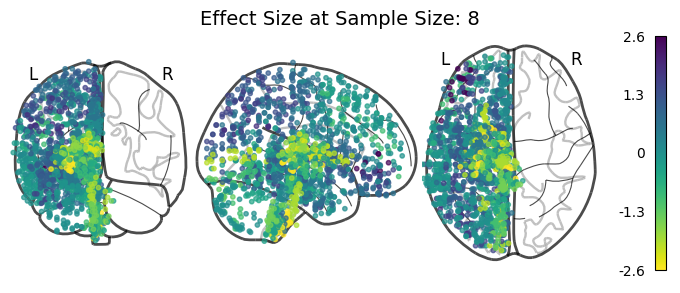

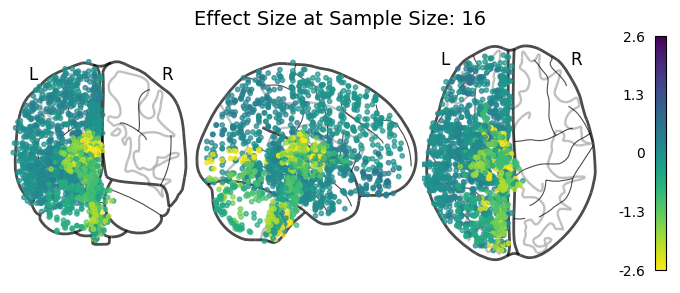

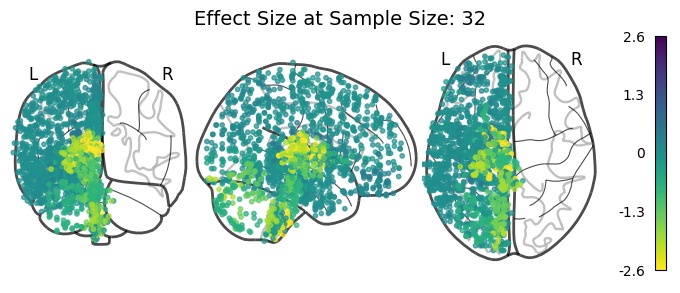

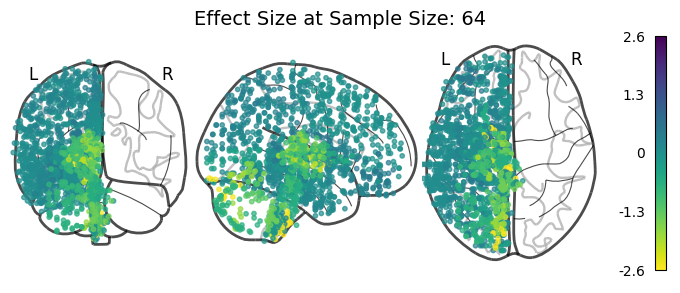

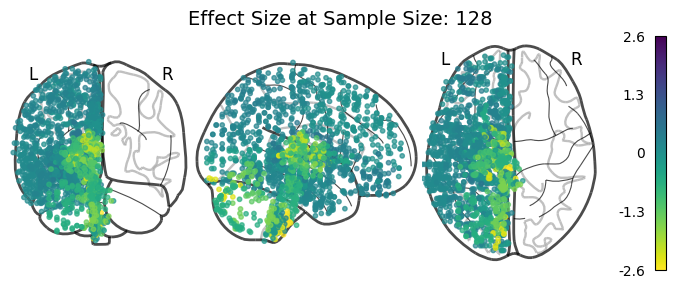

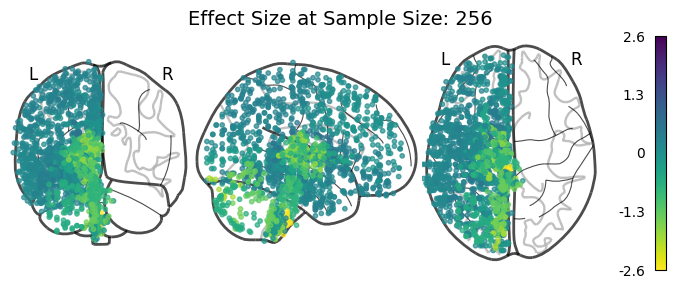

In [9]:
# Drop rows with missing MNI coordinates
df = df_stats_br_mni.copy(deep = True)

df = df.dropna(subset=['mni_x', 'mni_y', 'mni_z'])

# Extract MNI coordinates
mni_coords = df[['mni_x', 'mni_y', 'mni_z']].values

for i in range_with_powers_of_two:

    # Choose an effect size column to use for the colormap (e.g., 'effect_size_128')
    sample_size = "effect_size_" + str(i)
    effect_sizes = df[sample_size].values

    # Plot the brain with the points, using effect sizes for the colormap
    plotting.plot_markers(
        node_values=effect_sizes,  # Use effect sizes for the colormap
        node_coords=mni_coords,    # MNI coordinates
        colorbar=True,             # Enable colorbar to show the effect size scale
        # cmap='viridis',            # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm')
        node_size=10,# Adjust the size of the markers,
        node_vmin=0-np.max(df['effect_size_8']),
        node_vmax=np.max(df['effect_size_8'])
    )
    
    plt.suptitle(f'Effect Size at Sample Size: {i}', fontsize=14, y=1.05)
    # Show the plot
    plt.show()


### Effect Size to Brain Regions GIF saving

In [10]:
import imageio
import os
# Drop rows with missing MNI coordinates
df = df.dropna(subset=['mni_x', 'mni_y', 'mni_z'])

# Extract MNI coordinates
mni_coords = df[['mni_x', 'mni_y', 'mni_z']].values

# Define the range of sample sizes
range_with_powers_of_two = [2**i for i in range(3, 9)]

# Create a temporary directory to save the frames
temp_dir = "temp_frames"
os.makedirs(temp_dir, exist_ok=True)

# List to store the file paths of the frames
frame_files = []

# Loop through the sample sizes and create plots
for i in range_with_powers_of_two:
    # Choose an effect size column to use for the colormap
    sample_size = "effect_size_" + str(i)
    effect_sizes = df[sample_size].values

    # Plot the brain with the points, using effect sizes for the colormap
    plotting.plot_markers(
        node_values=effect_sizes,  # Use effect sizes for the colormap
        node_coords=mni_coords,    # MNI coordinates
        colorbar=True,             # Enable colorbar to show the effect size scale
        node_size=10,              # Adjust the size of the markers
        node_vmin=0 - np.max(df['effect_size_8']),
        node_vmax=np.max(df['effect_size_8'])
    )
    
    plt.suptitle(f'Effect Size at Sample Size: {i}', fontsize=14, y=1.05)
    
    # Save the plot as an image file
    frame_file = os.path.join(temp_dir, f'frame_{i}.png')
    plt.savefig(frame_file, bbox_inches='tight', dpi=100)
    plt.close()  # Close the plot to free up memory
    
    # Add the file path to the list
    frame_files.append(frame_file)

# Create a GIF from the frames
gif_file = PLOTS_PTH / Path("effect_size_animation.gif")
with imageio.get_writer(gif_file, mode='I', duration=50) as writer:
    for frame_file in frame_files:
        image = imageio.imread(frame_file)
        writer.append_data(image)

# Clean up: Remove the temporary frame files
for frame_file in frame_files:
    os.remove(frame_file)
os.rmdir(temp_dir)

print(f"GIF saved as {gif_file}")

GIF saved as /home/affectiva/git/Gene-Expression-Analysis/data/plots/effect_size_animation.gif


/tmp/ipykernel_2369601/2118662114.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_file)


### Visualizing Different Clusters

In [13]:
# Extract MNI coordinates for each cluster
coords_cluster1 = cluster1[['mni_x', 'mni_y', 'mni_z']].values
coords_cluster2 = cluster2[['mni_x', 'mni_y', 'mni_z']].values
coords_cluster3 = cluster3[['mni_x', 'mni_y', 'mni_z']].values

# Define a single-color colormap
cluster_cmap_0 = LinearSegmentedColormap.from_list('single_color', ['white', cluster_colors[0]], N=256)
cluster_cmap_1 = LinearSegmentedColormap.from_list('single_color', ['white', cluster_colors[1]], N=256)
cluster_cmap_2 = LinearSegmentedColormap.from_list('single_color', ['white', cluster_colors[2]], N=256)


# # Show the plot
plt.show()

Creating Images for Different Clusters

In [14]:
# Create separate images for each cluster with different values
cluster1_img = create_cluster_image(cluster1, 1)  # Value 1 for cluster 1
cluster2_img = create_cluster_image(cluster2, 2)  # Value 2 for cluster 2
cluster3_img = create_cluster_image(cluster3, 3)  # Value 3 for cluster 3

cluster1

,brain_region,effect_size_8,effect_size_16,effect_size_32,effect_size_64,effect_size_128,effect_size_256,structure_id,mni_x,mni_y,mni_z
0,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-50.6,5.7,6.8
1,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-28.4,-8.5,58.9
2,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-5.9,-26.2,75.9
3,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-43.0,-17.0,67.0
4,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-61.0,-6.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
1202,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-10.0,-7.0,-4.0
1203,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,3.0,-18.3,-5.9
1204,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-11.0,0.0,-6.0
1205,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-7.0,-9.0,-13.0


Plotting Function

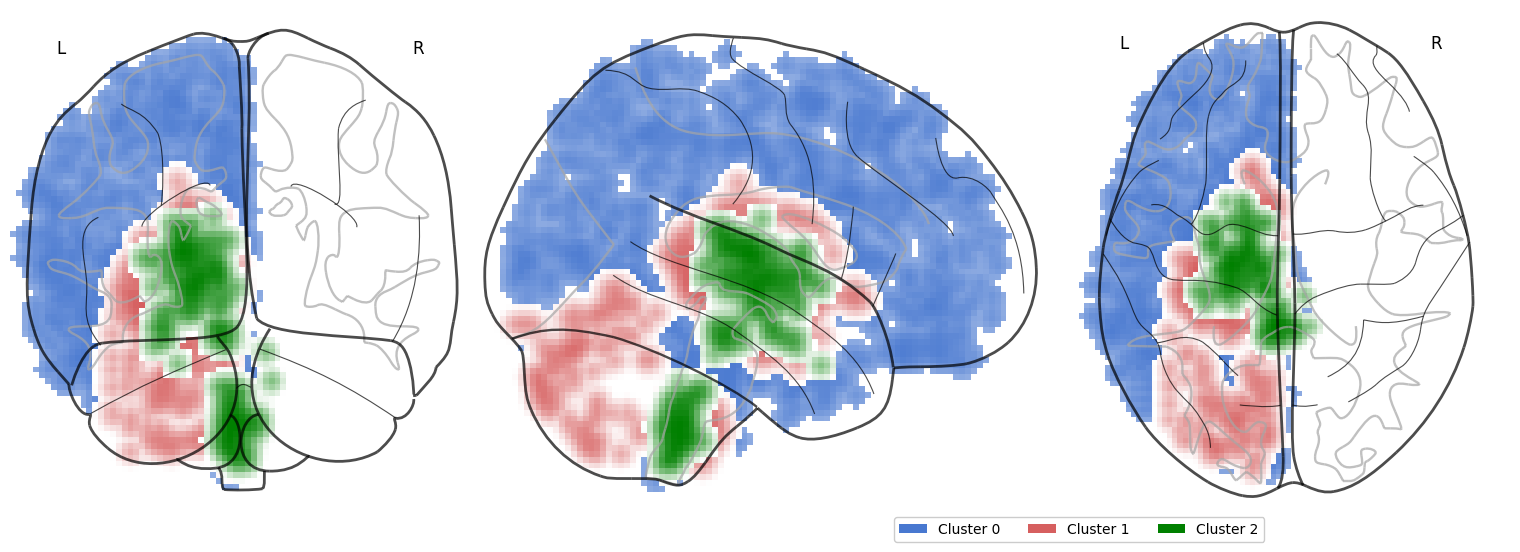

In [22]:
# Create figure
plt.figure(figsize=(15, 5))


# Plot with custom colormaps for smoother color transitions
display = plotting.plot_glass_brain(
    cluster1_img,
    cmap=cluster_cmap_0,      
    colorbar=False,
    plot_abs=False,
    figure=plt.gcf(),
    threshold=0.21  # Adjust threshold for smoother edges
)

display.add_overlay(
    cluster3_img,
    cmap=cluster_cmap_1,
    colorbar=False,
    threshold=0.21
)

# Add other clusters with custom colormaps
display.add_overlay(
    cluster2_img, 
    cmap=cluster_cmap_2,
    colorbar=False,
    threshold=0.21
)

# Add legend
legend_elements = [
    Patch(facecolor=cluster_colors[0], label='Cluster 0'),
    Patch(facecolor=cluster_colors[1], label='Cluster 1'),
    Patch(facecolor=cluster_colors[2], label='Cluster 2')
]


plt.legend(
    handles=legend_elements,
    loc='upper center',        # Position the legend at the top center
    bbox_to_anchor=(0., -0.0), # Move the legend below the plot
    ncol=3,                     # Arrange legend items in a single row
    framealpha=1                # Make the legend background opaque
)    
# plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.savefig(PLOTS_PTH / Path(f"brain_clusters.png"))

# Adjust layout to ensure the plot and legend fit without overlap
plt.show()

In [27]:
# Create separate images for each cluster with different values
cluster1_img = create_cluster_image(cluster1, 1)  # Value 1 for cluster 1
cluster2_img = create_cluster_image(cluster2, 2)  # Value 2 for cluster 2
cluster3_img = create_cluster_image(cluster3, 3)  # Value 3 for cluster 3

all_regions = create_cluster_image(df_stats_br_mni, 1)  # Value 1 for cluster 1

cluster1

,brain_region,effect_size_8,effect_size_16,effect_size_32,effect_size_64,effect_size_128,effect_size_256,structure_id,mni_x,mni_y,mni_z
0,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-50.6,5.7,6.8
1,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-28.4,-8.5,58.9
2,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-5.9,-26.2,75.9
3,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-43.0,-17.0,67.0
4,4014,0.763522,0.353605,0.380905,0.385458,0.378387,0.252974,4014,-61.0,-6.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
1202,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-10.0,-7.0,-4.0
1203,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,3.0,-18.3,-5.9
1204,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-11.0,0.0,-6.0
1205,13005,-0.539211,-0.518028,-0.557842,-0.600964,-0.439613,-0.364578,13005,-7.0,-9.0,-13.0


In [16]:
cluster_0 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_0_filtered.csv'))
cluster_1 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_1_filtered.csv'))
cluster_2 = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('cluster_2_filtered.csv'))
ontology = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('Ontology.csv'))

In [17]:
# Assuming 'df' is your DataFrame
cluster_0_brain_regions_list = cluster_0["brain_region"].unique().tolist()
cluster_1_brain_regions_list = cluster_1["brain_region"].unique().tolist()
cluster_2_brain_regions_list = cluster_2["brain_region"].unique().tolist()

cluster_brain_regions = {
    0 : cluster_0_brain_regions_list,
    1 : cluster_1_brain_regions_list,
    2 : cluster_2_brain_regions_list    
}

cluster_brain_regions_names = {}

cluster_0_brain_regions, cluster_1_brain_regions, cluster_2_brain_regions = [],[],[]
cluster_brain_regions_names = {
    0 : cluster_0_brain_regions,
    1 : cluster_1_brain_regions,
    2 : cluster_2_brain_regions    
}
for i in range(0,3):
    for br in cluster_brain_regions[i]:
        cluster_brain_regions_names[i].append(ontology.loc[ontology['id'] == br, 'name'].str.split(",", n=1).str[0].tolist()[0])



with open(OUTPUT_DATA / Path("cluster_0_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[0]:
        f.write(f"{line}\n")


with open(OUTPUT_DATA / Path("cluster_1_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[1]:
        f.write(f"{line}\n")
        
with open(OUTPUT_DATA / Path("cluster_2_brain_region_names.txt"), 'w') as f:
    for line in cluster_brain_regions_names[2]:
        f.write(f"{line}\n")
